# CNN Model 🔍

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from pathlib import Path
import json
import transformers
import numpy as np
from utils import *
import matplotlib as mpl
from models import CNN9, CNN100
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['figure.figsize'] = [7, 5]
mpl.rcParams['savefig.pad_inches'] = 0

## 9-way Composer

In [2]:
output_model9_path = Path("./cnn9/")
output_model9_path.mkdir(exist_ok=True)
batch_size = 64
epochs = 64
learning_rate = 5e-4
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

### Load data and define model

$60/15/15$ split b/w train, val, test data


$X, y$ are numpy arrays of size $(n, 64, 62), (n,)$ respectively

In [3]:
train_dataset, val_dataset, test_dataset, label2id, id2label = create_dataset("/mnt/data0/BSCRC/data/9_way_dataset.pkl", add_pad=False)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model9 = CNN9()
if torch.cuda.device_count() > 1:
    model9 = nn.DataParallel(model9)
model9.to(device)

optimizer = torch.optim.Adam(model9.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Train classifier

In [5]:
num_training_steps = len(trainloader) * epochs
progress_bar = tqdm(range(num_training_steps))
log_history = []
lr_scheduler = transformers.get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

for epoch in range(epochs):

    model9.train()
    train_loss = 0.0
    
    # training loop
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model9(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
        train_loss += loss.item()

    train_loss /= len(trainloader)
    
    model9.eval()
    val_loss = 0.0
    correct1, correct5, total = 0, 0, 0

    # validation loop
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model9(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, top1 = torch.topk(outputs.data, k=1, dim=1)
            _, top5 = torch.topk(outputs.data, k=5, dim=1)

            total += labels.size(0)
            correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
            correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

    val_loss /= len(valloader)
    val_acc1 = correct1 / total
    val_acc5 = correct5 / total

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, val_acc1: {val_acc1:.3f}, val_acc5: {val_acc5:.3f}")
    log_history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_acc1": val_acc1, "val_acc5": val_acc5})
    torch.save(model9.state_dict(), f"{output_model9_path}/epoch_{epoch}.pth")

with open(output_model9_path/"log_history.json", "w") as f:
    json.dump(log_history, f) 

  0%|          | 0/28032 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 2.062, Val Loss: 1.926, val_acc1: 0.261, val_acc5: 0.842
Epoch: 1, Train Loss: 1.916, Val Loss: 1.824, val_acc1: 0.290, val_acc5: 0.854
Epoch: 2, Train Loss: 1.805, Val Loss: 1.768, val_acc1: 0.348, val_acc5: 0.870
Epoch: 3, Train Loss: 1.752, Val Loss: 1.737, val_acc1: 0.355, val_acc5: 0.861
Epoch: 4, Train Loss: 1.715, Val Loss: 1.764, val_acc1: 0.339, val_acc5: 0.864
Epoch: 5, Train Loss: 1.690, Val Loss: 1.695, val_acc1: 0.372, val_acc5: 0.861
Epoch: 6, Train Loss: 1.670, Val Loss: 1.689, val_acc1: 0.386, val_acc5: 0.871
Epoch: 7, Train Loss: 1.651, Val Loss: 1.672, val_acc1: 0.407, val_acc5: 0.868
Epoch: 8, Train Loss: 1.635, Val Loss: 1.638, val_acc1: 0.423, val_acc5: 0.877
Epoch: 9, Train Loss: 1.618, Val Loss: 1.672, val_acc1: 0.387, val_acc5: 0.866
Epoch: 10, Train Loss: 1.607, Val Loss: 1.615, val_acc1: 0.428, val_acc5: 0.863
Epoch: 11, Train Loss: 1.595, Val Loss: 1.612, val_acc1: 0.399, val_acc5: 0.874
Epoch: 12, Train Loss: 1.586, Val Loss: 1.626, val

### Plot training curves

In [10]:
def plot_train(path):

    plt.style.use("ggplot")

    with open(path/"log_history.json", "r") as f:
        log = json.load(f)

    epochs = [metric['epoch'] for metric in log]
    train_loss = [metric['train_loss'] for metric in log]
    val_loss = [metric['val_loss'] for metric in log]
    val_acc1 = [metric['val_acc1'] for metric in log]
    val_acc5 = [metric['val_acc5'] for metric in log]

    plt.plot(epochs, train_loss, color="royalblue", label=f'Train (last {train_loss[-1]:.3f})', linewidth=2.5)
    plt.plot(epochs, val_loss, color="lightseagreen", label=f'Validation (last {val_loss[-1]:.3f})', linewidth=2.5)
    plt.scatter(epochs, train_loss, color="royalblue")
    plt.scatter(epochs, val_loss, color="lightseagreen")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tick_params(left=False, right=False)
    plt.legend(fontsize=13, fancybox=True, borderpad=0.8, labelspacing=0.8, borderaxespad=1.8, framealpha=0.7, facecolor='white')
    
    print(f"Validation Loss: {val_loss[-1]:.5f}")
    print(f"Train Loss: {train_loss[-1]:.5f}")
    print(f"Validation Acc@1: {val_acc1[-1]:.5f}")
    print(f"Validation Acc@5: {val_acc5[-1]:.5f}")
    plt.show()

Validation Loss: 1.46485
Train Loss: 1.37606
Validation Acc@1: 0.48826
Validation Acc@5: 0.90022


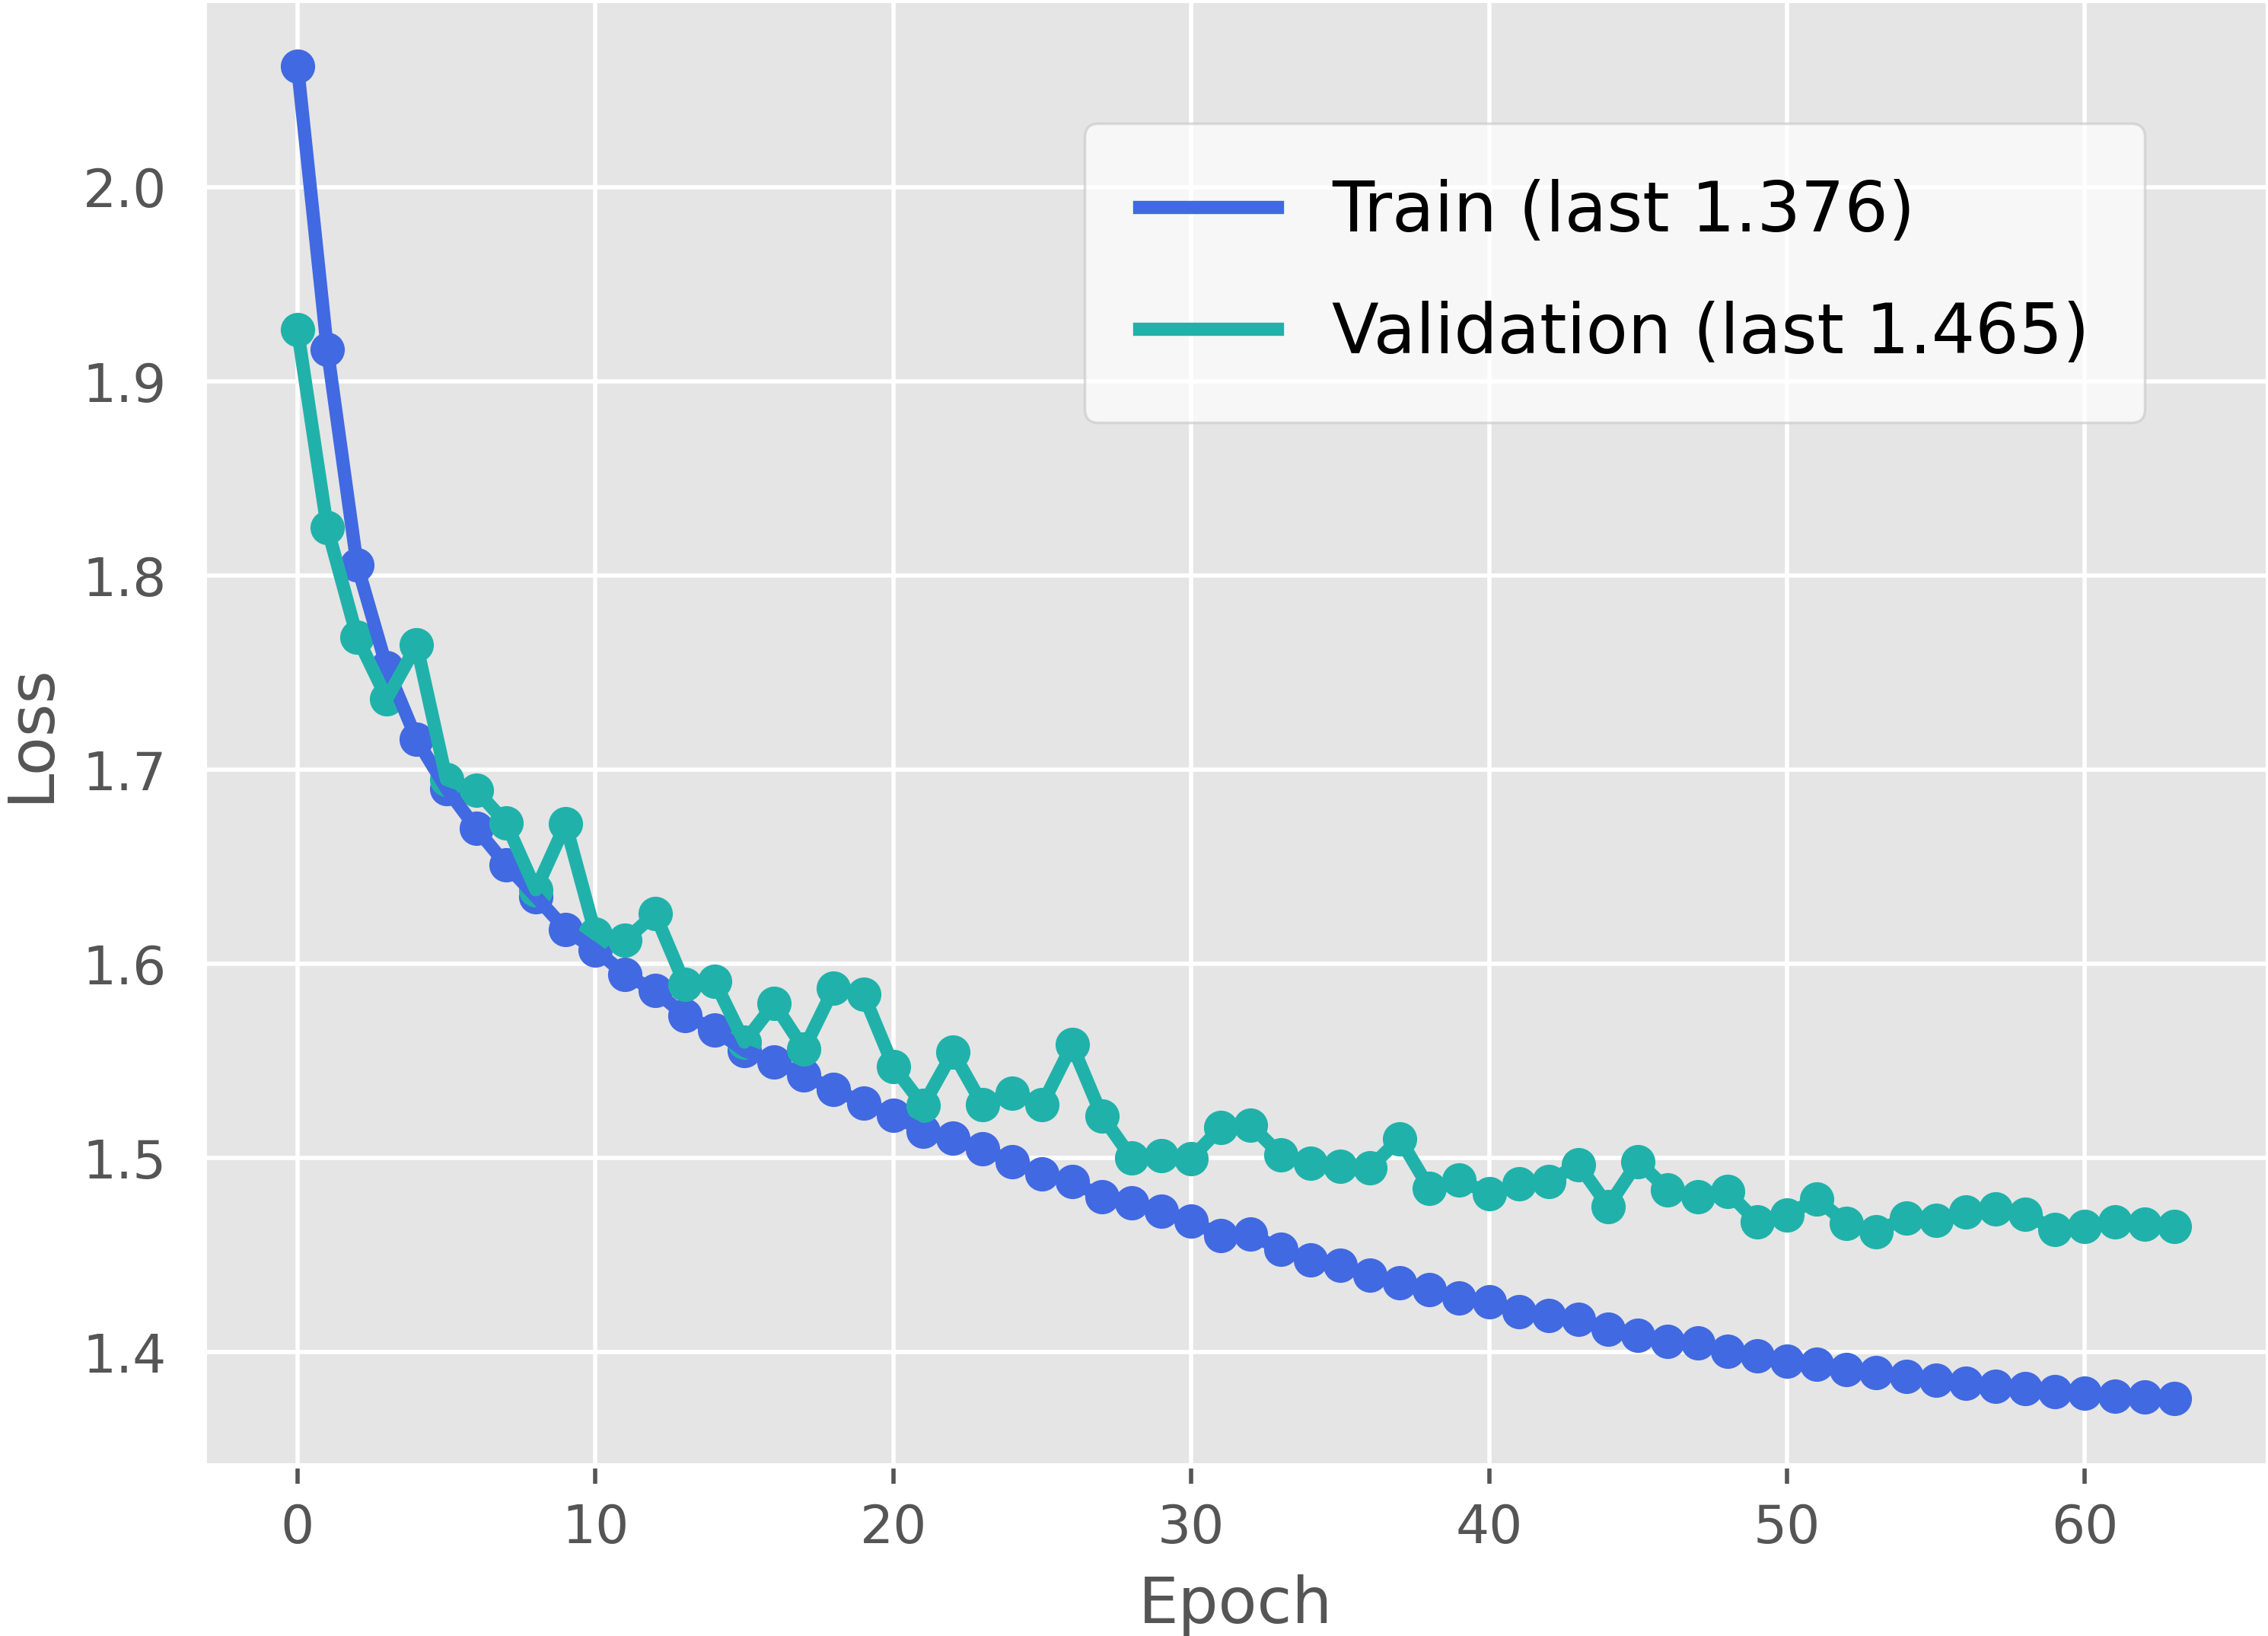

In [11]:
plot_train(output_model9_path)

### Save last epoch validation/test predictions to disk

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model9 = CNN9()
if torch.cuda.device_count() > 1:
    model9 = nn.DataParallel(model9)
model9.to(device)
model9.load_state_dict(torch.load(output_model9_path/"epoch_31.pth"))

model9.eval()

# validation evaluation loop
val_preds, val_correct1, val_correct5, val_total = [], 0, 0, 0
with torch.no_grad():
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model9(inputs)

        _, top1 = torch.topk(outputs.data, k=1, dim=1)
        _, top5 = torch.topk(outputs.data, k=5, dim=1)

        val_total += labels.size(0)
        val_correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
        val_correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

        val_preds.append(outputs.cpu().numpy())

val_acc1 = val_correct1 / val_total
val_acc5 = val_correct5 / val_total

print(f"Validation Accuracy Top 1: {val_acc1}")
print(f"Validation Accuracy Top 5: {val_acc5}")

val_preds = np.concatenate(val_preds, axis=0)
with open(f"{output_model9_path}/val_preds.npy", "wb") as f:
    np.save(f, val_preds)

Validation Accuracy Top 1: 0.482592037314676
Validation Accuracy Top 5: 0.8902215558887223


In [13]:
# test evaluation loop
test_preds, test_correct1, test_correct5, test_total = [], 0, 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model9(inputs)

        _, top1 = torch.topk(outputs.data, k=1, dim=1)
        _, top5 = torch.topk(outputs.data, k=5, dim=1)

        test_total += labels.size(0)
        test_correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
        test_correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

        test_preds.append(outputs.cpu().numpy())

test_acc1 = test_correct1 / test_total
test_acc5 = test_correct5 / test_total

print(f"Test Accuracy Top 1: {test_acc1}")
print(f"Test Accuracy Top 5: {test_acc5}")

test_preds = np.concatenate(test_preds, axis=0)
with open(f"{output_model9_path}/test_preds.npy", "wb") as f:
    np.save(f, test_preds)

Test Accuracy Top 1: 0.3916375145760453
Test Accuracy Top 5: 0.8987173080126604


## 100-way Composer

In [14]:
output_model100_path = Path("./cnn100/")
os.makedirs(output_model100_path , exist_ok=True)
batch_size = 64
epochs = 64
learning_rate = 5e-4
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

### Load data and define model

In [15]:
train_dataset, val_dataset, test_dataset, label2id, id2label = create_dataset("/mnt/data0/BSCRC/data/100_way_dataset.pkl", add_pad=False)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model100 = CNN100()
if torch.cuda.device_count() > 1:
    model100 = nn.DataParallel(model100)
model100.to(device)

optimizer = torch.optim.Adam(model100.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Train classifier

In [17]:
num_training_steps = len(trainloader) * epochs
progress_bar = tqdm(range(num_training_steps))
log_history = []
lr_scheduler = transformers.get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

for epoch in range(epochs):

    model100.train()
    train_loss = 0.0
    
    # training loop
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model100(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
        train_loss += loss.item()

    train_loss /= len(trainloader)
    
    model100.eval()
    val_loss = 0.0
    correct1, correct5, total = 0, 0, 0

    # validation loop
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model100(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, top1 = torch.topk(outputs.data, k=1, dim=1)
            _, top5 = torch.topk(outputs.data, k=5, dim=1)

            total += labels.size(0)
            correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
            correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

    val_loss /= len(valloader)
    val_acc1 = correct1 / total
    val_acc5 = correct5 / total

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, val_acc1: {val_acc1:.3f}, val_acc5: {val_acc5:.3f}")
    log_history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_acc1": val_acc1, "val_acc5": val_acc5})
    torch.save(model100.state_dict(), f"{output_model100_path}/epoch_{epoch}.pth")

with open(output_model100_path/"log_history.json", "w") as f:
    json.dump(log_history, f) 

  0%|          | 0/70016 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 4.550, Val Loss: 4.490, val_acc1: 0.034, val_acc5: 0.106
Epoch: 1, Train Loss: 4.399, Val Loss: 4.332, val_acc1: 0.056, val_acc5: 0.171
Epoch: 2, Train Loss: 4.278, Val Loss: 4.274, val_acc1: 0.058, val_acc5: 0.176
Epoch: 3, Train Loss: 4.226, Val Loss: 4.248, val_acc1: 0.062, val_acc5: 0.190
Epoch: 4, Train Loss: 4.195, Val Loss: 4.223, val_acc1: 0.063, val_acc5: 0.200
Epoch: 5, Train Loss: 4.168, Val Loss: 4.210, val_acc1: 0.070, val_acc5: 0.209
Epoch: 6, Train Loss: 4.143, Val Loss: 4.198, val_acc1: 0.071, val_acc5: 0.204
Epoch: 7, Train Loss: 4.121, Val Loss: 4.180, val_acc1: 0.072, val_acc5: 0.216
Epoch: 8, Train Loss: 4.099, Val Loss: 4.163, val_acc1: 0.076, val_acc5: 0.221
Epoch: 9, Train Loss: 4.080, Val Loss: 4.162, val_acc1: 0.075, val_acc5: 0.219
Epoch: 10, Train Loss: 4.062, Val Loss: 4.146, val_acc1: 0.079, val_acc5: 0.229
Epoch: 11, Train Loss: 4.044, Val Loss: 4.139, val_acc1: 0.080, val_acc5: 0.226
Epoch: 12, Train Loss: 4.027, Val Loss: 4.135, val

### Plot training curves

Validation Loss: 3.96729
Train Loss: 3.67210
Validation Acc@1: 0.11547
Validation Acc@5: 0.29987


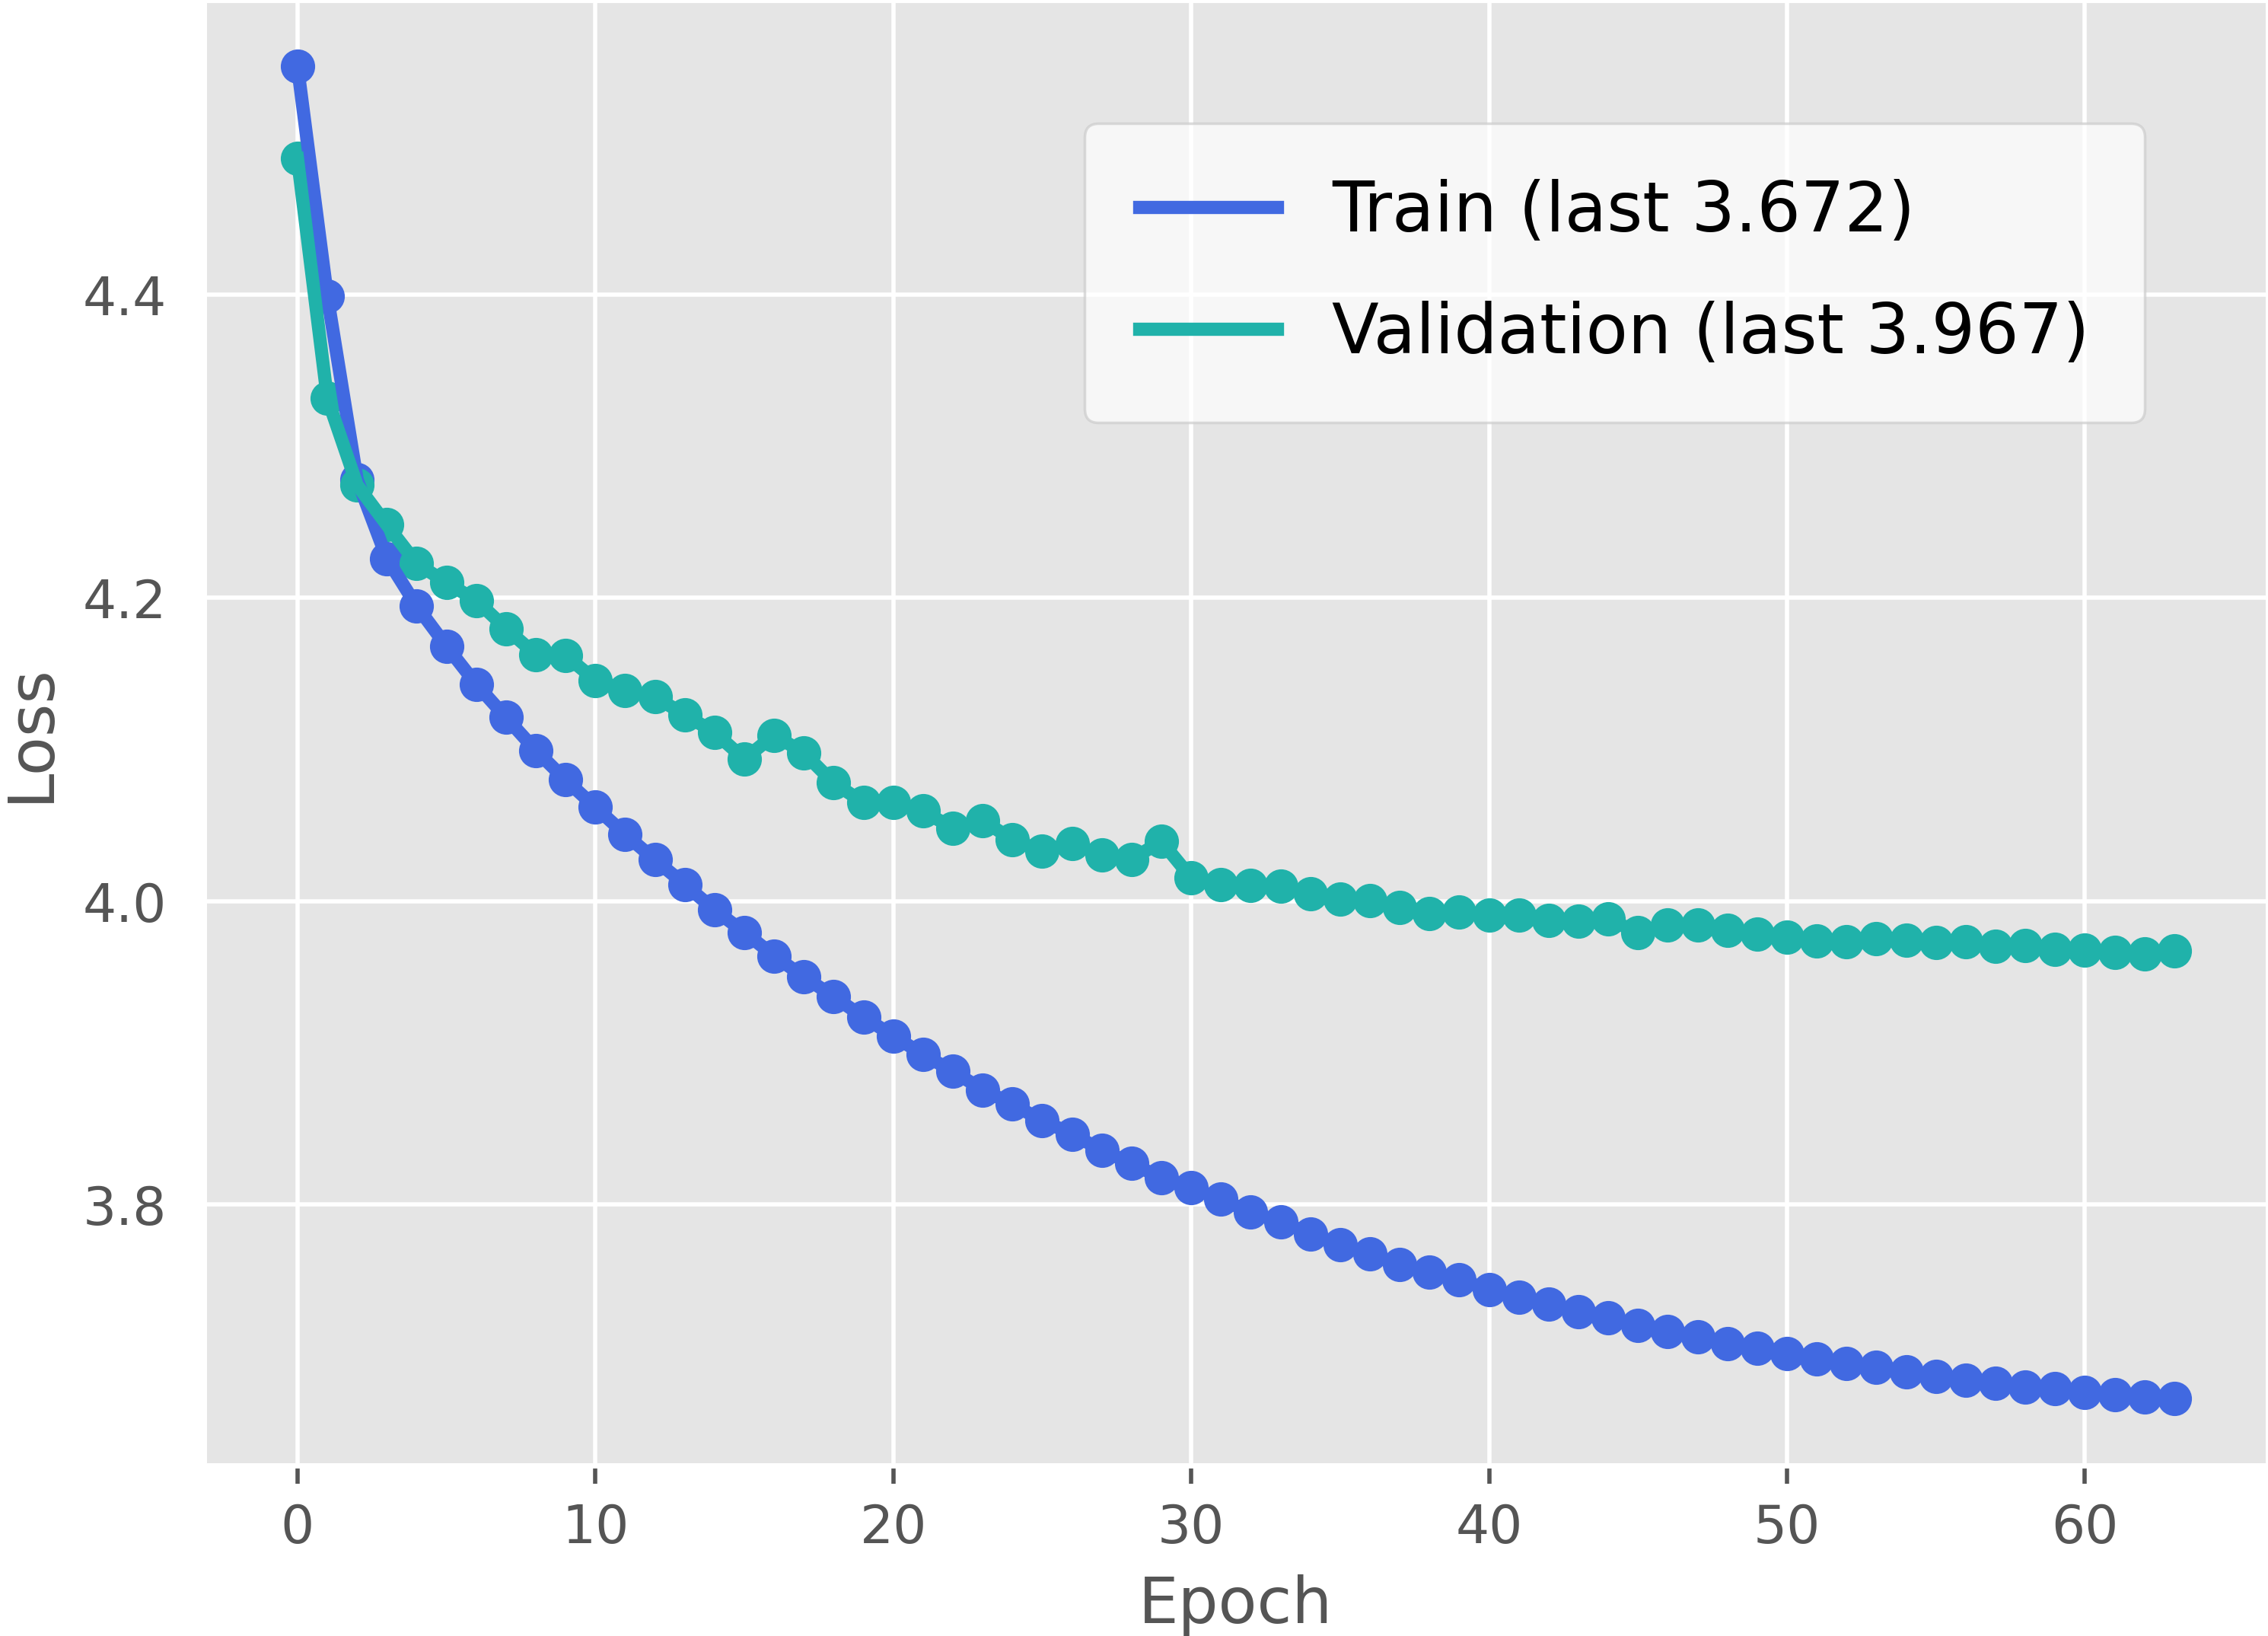

In [21]:
plot_train(output_model100_path)

### Save last epoch validation/test predictions to disk

In [22]:
model100 = CNN100()
if torch.cuda.device_count() > 1:
    model100 = nn.DataParallel(model100)
model100.to(device)
model100.load_state_dict(torch.load(output_model100_path/"epoch_31.pth"))

model100.eval()

# validation evaluation loop
val_preds, val_correct1, val_correct5, val_total = [], 0, 0, 0
with torch.no_grad():
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model100(inputs)

        _, top1 = torch.topk(outputs.data, k=1, dim=1)
        _, top5 = torch.topk(outputs.data, k=5, dim=1)

        val_total += labels.size(0)
        val_correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
        val_correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

        val_preds.append(outputs.cpu().numpy())

val_acc1 = val_correct1 / val_total
val_acc5 = val_correct5 / val_total

print(f"Validation Accuracy Top 1: {val_acc1}")
print(f"Validation Accuracy Top 5: {val_acc5}")

val_preds = np.concatenate(val_preds, axis=0)
with open(f"{output_model100_path}/val_preds.npy", "wb") as f:
    np.save(f, val_preds)

Validation Accuracy Top 1: 0.10786666666666667
Validation Accuracy Top 5: 0.2834


In [23]:
# test evaluation loop
test_preds, test_correct1, test_correct5, test_total = [], 0, 0, 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model100(inputs)

        _, top1 = torch.topk(outputs.data, k=1, dim=1)
        _, top5 = torch.topk(outputs.data, k=5, dim=1)

        test_total += labels.size(0)
        test_correct1 += torch.sum(top1 == labels[:, None], dim=1).sum().item()
        test_correct5 += torch.sum(top5 == labels[:, None], dim=1).sum().item()

        test_preds.append(outputs.cpu().numpy())

test_acc1 = test_correct1 / test_total
test_acc5 = test_correct5 / test_total

print(f"Test Accuracy Top 1: {test_acc1}")
print(f"Test Accuracy Top 5: {test_acc5}")

test_preds = np.concatenate(test_preds, axis=0)
with open(f"{output_model100_path}/test_preds.npy", "wb") as f:
    np.save(f, test_preds)

Test Accuracy Top 1: 0.105
Test Accuracy Top 5: 0.2824
